In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
sx = qt.sigmax();sy = qt.sigmay(); sz = qt.sigmaz(); s0 = qt.qeye(2); sm = qt.sigmam(); sp = qt.sigmap()

In [35]:
# Define the Hamiltonian [[E13, t23,t01,0],[t23,E12, 0, t01],[t01,0,E03,t23],[0,t01,t23,E02]]
def hamiltonian(E13,E12,E03,E02,t23,t01):
    return np.array([[E13, t23,t01,0],[t23,E12, 0, t01],[t01,0,E03,t23],[0,t01,t23,E02]])


# convert Hamiltonian to qutip object and add contribution from resonance gate
def hamiltonian_qutip(E13,E12,E03,E02,t23,t01, lever_arms_res, Vr):
    E13 = E13 + Vr*(lever_arms_res[1]+lever_arms_res[3])
    E12 = E12 + Vr*(lever_arms_res[1]+lever_arms_res[2])
    E03 = E03 + Vr*(lever_arms_res[0]+lever_arms_res[3])
    E02 = E02 + Vr*(lever_arms_res[0]+lever_arms_res[2])
    return qt.Qobj(hamiltonian(E13,E12,E03,E02,t23,t01))


def compute_q_capacitance(Hvr, lever_arms_res,  Vr = [-1e-3,1e-3]):
    #We compute capacitances using the formula e alpha_i dP_i/dV
    Es = []
    for V in Vr:
        Es.append(Hvr(V).eigenstates()[1][0])
    dP_states = np.array(Es[1])**2 - np.array(Es[0])**2 #Change in occ prob in basis |13>,|12>,|03>,|02>
    dP0 = dP_states[2] + dP_states[3]  #Probability of occ dot 0
    dP1 = dP_states[0] + dP_states[1] #Probability of occ dot 1
    dP2 = dP_states[1] + dP_states[3] #Probability of occ dot 2
    dP3 = dP_states[0] + dP_states[2] #Probability of occ dot 3
    dP = np.array([dP0,dP1,dP2,dP3]).reshape(4)
    dV = Vr[1]-Vr[0] #dV
    return np.dot(dP,lever_arms_res)/dV


#Parameters (mock)

lever_arms_res = np.array([np.exp(-r) for r in range(4)])   
#Energies of each state E_ij = mu_i + mu_j + U_{ij}
mu = [0,0.1,0,0.2] #Chemical potentials
U = np.zeros((4,4)) 
U[0,3] = 0.2
U[0,2] = 0.5
U[1,3] = 0.5
U[1,2] = 1


E = np.zeros((4,4)) 
indxs = [(1,3),(1,2),(0,3),(0,2)] #Indices of the energies to compute
for inds in indxs:
    E[inds] = mu[inds[0]] + mu[inds[1]] + U[inds]
    
# Tunneling rates
t = 1

Hvr = lambda Vr: hamiltonian_qutip(E[1,3],E[1,2],E[0,3],E[0,3],t,t,lever_arms_res, Vr)

# Compute the capacitance
deps01 = np.linspace(-5,5,51)
Cs = []
for deps in deps01:
    mu = [deps/2,-deps/2,0,0.2]
    for inds in indxs:
        E[inds] = mu[inds[0]] + mu[inds[1]] + U[inds]
    C = compute_q_capacitance(Hvr, lever_arms_res, Vr = [-1e-4,1e-4])
    Cs.append(C)

In [29]:
Cs5 = Cs


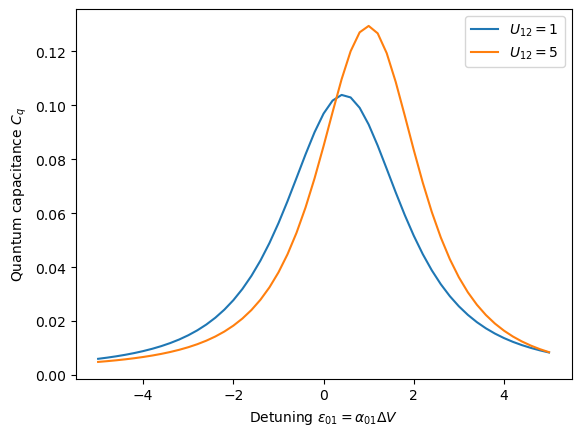

In [33]:
plt.plot(deps01,np.abs(Cs), label =r"$U_{12} = 1$")
plt.plot(deps01,np.abs(Cs5), label =r"$U_{12} = 5$")
plt.xlabel(r"Detuning $\epsilon_{01} = \alpha_{01}\Delta V$")
plt.ylabel("Quantum capacitance $C_q$")
plt.legend()